In [44]:
import matplotlib.pyplot as plt
import freckles
import numpy as np
import healpy
from scipy.optimize import minimize
from scipy.stats import norm

# Component separation

The component separation code will expect data in a dictionary with keywords `data` and `noisevar`. `data` expects an array with the shape (`npol`, `npix`, `nfreq`), and noisevar expects shape (`npol`, `npix`, `nfreqs`). The first two dimensions are flattened, so the same index is assumed for $Q$ and $U$, and they are treated equivalently.

## InstrumentModel

The instrument is defined by a dictionary with keys `nu` and `bps`.

## SkyModel

`freckles.separation.SkyModel` is defined by a list of component names.

## MapLike

`MapLike` is initialized with a dictionary of the following keywords:

- `data`
- `noisevar`
- `var_pars`
- `fixed_pars`
- `var_prior_mean`
- `var_prior_width`
- `var_prior_type`

In [3]:
def get_bps(frequencies):
    """ Method to calculate and return a delta function bandpass in the
    correct form for `freckles.separation.MapLike` from an array of frequencies.

    Parameters
    ----------
    frequencies: array_like(float)
        Array of frequencies at which to center the delta bandpasses.

    Returns
    -------
    list(dict)
        List of dictionaries, each dictionary contains two keys,
        'nu', an array specifying samples within the bandpass, and
        'bps', containing a correspondin weight for each sample in
        frequency.
    """
    bps = np.array([
        {
            'nu': np.array([freq - 0.1, freq + 0.1]),
            'bps': np.array([1])
        } for freq in frequencies])
    return bps

def fake_data():
    return data

In [4]:
freqs = np.array([20., 30., 90., 143., 220., 350., 500.])

In [5]:
nres = 40
syncsed = freckles.separation.components.syncpl(freqs, 23., -3.1)
dustsed = freckles.separation.components.dustmbb(freqs, 353., 1.55, 20.)
sync_template = np.random.randn(nres, nres).reshape(nres ** 2)
dust_template = np.random.randn(nres, nres).reshape(nres ** 2)

In [6]:
syncobs = sync_template[None, :, None] * syncsed[None, None, :] * 10
dustobs = dust_template[None, :, None] * dustsed[None, None, :] * 10

In [17]:
sigma_pix = 1. * np.ones((1, nres ** 2, len(freqs))) * (syncsed + dustsed)[None, None, :]
noise = np.random.randn(1, nres ** 2, len(freqs)) * sigma_pix
noisevar = sigma_pix ** 2

sky = syncobs + dustobs + noise

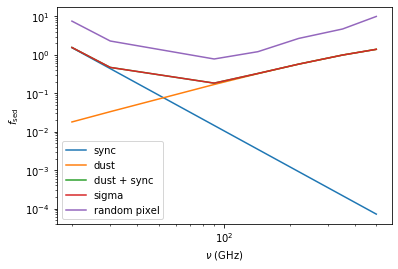

In [18]:
fig, ax = plt.subplots(1, 1)
ax.loglog(freqs, syncsed, label='sync')
ax.loglog(freqs, dustsed, label='dust')
ax.loglog(freqs, dustsed + syncsed, label='dust + sync')
ax.loglog(freqs, sigma_pix[0, 0], label='sigma')
ax.loglog(freqs, np.abs(sky[0, 2, :]), label='random pixel')
ax.legend()
ax.set_xlabel(r"$\nu~{\rm (GHz)}$")
ax.set_ylabel(r"$f_{\rm sed}$");

In [19]:
instrumentmodel = freckles.separation.InstrumentModel(get_bps(freqs))

skymodel = freckles.separation.SkyModel(['syncpl', 'dustmbb'])

config_dict = {
    'data': sky,
    'noisevar': noisevar,
    'var_pars': ["beta_d", "beta_s"],
    'fixed_pars': {"nu_ref_d": 353., "nu_ref_s": 23., "T_d": 20.},
    'var_prior_mean': [1.55, -3.1],
    'var_prior_width': [0.1, 0.1],
    'var_prior_type': ['gauss', 'gauss']
}

maplike = freckles.separation.MapLike(config_dict, skymodel, instrumentmodel)

## Maximum Likelihood $\theta$

In [20]:
p0 = np.array([1.5, -3.])
fmat = maplike.f_matrix(p0)

In [ ]:
res = freckles.separation.sampling.run_minimize(maplike.marginal_spectral_likelihood, p0)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
plt.subplots_adjust(hspace=0.1)
for a in ax.flatten():
    a.axis('off')
ax[0, 0].imshow(dust_template.reshape(nres, nres))
ax[0, 0].set_title("Input dust")
ax[0, 1].imshow(maplike.get_amplitude_mean(res['params_ML'])[:, 1].reshape(nres, nres))
ax[0, 1].set_title("ML dust")
ax[1, 0].imshow(sync_template.reshape(nres, nres))
ax[1, 0].set_title("Input sync")
ax[1, 1].imshow(maplike.get_amplitude_mean(res['params_ML'])[:, 0].reshape(nres, nres))
ax[1, 1].set_title("ML sync")

## Fisher prediction for uncertainties on $\theta$

In [41]:
fish = freckles.separation.sampling.run_fisher(maplike.marginal_spectral_likelihood, p0, ml_first=True)

In [73]:
fisher_cov_mat = np.linalg.inv(fish['fisher_m']) 
fish_sigma_beta_d = fisher_cov_mat[0, 0]
fish_sigma_beta_s = fisher_cov_mat[1, 1]

fish_betad = norm(loc=fish['params_cent'][0], scale=np.sqrt(fish_sigma_beta_d))
fish_betas = norm(loc=fish['params_cent'][1], scale=np.sqrt(fish_sigma_beta_s))

In [74]:
print(np.std(sample_res['chains'][:, 0]))
print(np.std(sample_res['chains'][:, 1]))

0.002065239058458388
0.009722634810149946


## Sampling $\theta$

In [75]:
sample_res = freckles.separation.sampling.run_emcee(maplike.marginal_spectral_likelihood, p0)

/home/bthorne/anaconda3/envs/freckles/lib/python3.7/site-packages/emcee/ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,


(100, 12.640953581176483)
(200, 22.280284079199642)


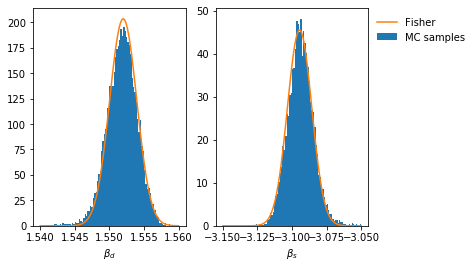

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
bininfo1 = ax[0].hist(sample_res['chains'][:, 0], range=[1.54, 1.56], bins=100, density=True)
ax[0].plot(bininfo1[1], fish_betad.pdf(bininfo1[1]))
ax[0].set_xlabel(r"$\beta_d$")
bininfo2 = ax[1].hist(sample_res['chains'][:, 1], range=[-3.15, -3.05], bins=100, density=True, label='MC samples')
ax[1].plot(bininfo2[1], fish_betas.pdf(bininfo2[1]), label='Fisher')
ax[1].set_xlabel(r"$\beta_s$")
ax[1].legend(bbox_to_anchor=(1., 1.), loc='upper left', frameon=False)

Init signature: slice(self, /, *args, **kwargs)
Docstring:     
slice(stop)
slice(start, stop[, step])

Create a slice object.  This is used for extended slicing (e.g. a[0:10:2]).
Type:           type
Subclasses:     
